In [1]:
# Import Statements

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading the data 
df_diabetes = pd.read_csv('diabetic_data_train.csv')

Pre Processing and sanitizing the data

In [3]:
# Diagnosis Mapping according to the ICD-9 Codes they are grouped - [2]
def diagnosis_mapping(df):
  list_diag = ['diag_1','diag_2','diag_3']
  for dg in list_diag:
    list1 = df[dg].unique()
    for j in list1:
      j = str(j)
      if j.startswith('250.') or j.startswith('365.'):
        df[dg].replace(j,4,inplace=True)
      elif j.startswith('E') or j.startswith('V'):
        df[dg].replace(j,9,inplace=True) 
      elif j.startswith('missing'):
        df[dg].replace(j,10,inplace=True)
      else:
        try:
          i = int(j)
          if (i in range(390,460)) or i==785:
            df[dg].replace(j,1,inplace=True)
          elif (i in range(460,520)) or i==786:
            df[dg].replace(j,2,inplace=True)
          elif (i in range(520,580) or i==787):
            df[dg].replace(j,3,inplace=True)
          elif (i in range(800,1000)):
            df[dg].replace(j,5,inplace=True)
          elif (i in range(710,740)):
            df[dg].replace(j,6,inplace=True)
          elif (i in range(580,630) or i==788):
            df[dg].replace(j,7,inplace=True)
          elif i in range(140,240):
            df[dg].replace(j,8,inplace=True)
          else:
            df[dg].replace(j,9,inplace=True)
        except:
          pass    

In [4]:
# Function for discharge_disposition_id preprocessing 
def discharge(df):
  # Patients who have the discharge_disposition_id of either hospice or expired are removed from the dataset.
  list_death_ids = [11,13,14,19,20,21]
  for i in list_death_ids:
    df.drop(df.loc[df['discharge_disposition_id']==i].index, inplace=True)

In [5]:
# Function for medical_specialty preprocessing 
# They are grouped according to their speciality [1]
def medical_specialty(df):
  list1 = df['medical_specialty'].unique()
  for i in list1:
    if(i=='InternalMedicine'):
      df['medical_specialty'].replace(i,1,inplace=True)
    elif (i=='Cardiology'):
      df['medical_specialty'].replace(i,2,inplace=True)
    elif i.startswith('Surgery'):
      df['medical_specialty'].replace(i,3,inplace=True)
    elif i=='Family/GeneralPractice':
      df['medical_specialty'].replace(i,4,inplace=True)
    elif i=='missing':
      df['medical_specialty'].replace(i,5,inplace=True)
    else:
      df['medical_specialty'].replace(i,6,inplace=True)

In [6]:
# Dropping Columns 
#Unnamed: 0    0
#encounter_id  1
#patient_nbr   2
# Above 3 Columns are identifires so they are removed from database
# weight- Sparase and not included in analysis [1] 6 - Weight contains 97% Null so removed from database
# payer_code-removed since high number of missing columns and not considered relevant to outcome[1] 11 

def drop_columns(df):
    df.drop(['Unnamed: 0','encounter_id','patient_nbr','weight','payer_code'],axis=1,inplace=True)

In [7]:
#Encoding / Grouping the columns: 
def encoding_data(df):

  # Readmitted columns is being remapped according to the problem statement
  readmitted_mapper = {'NO':0,'>30':0,'<30':1}
  df["readmitted"] = df["readmitted"].replace(readmitted_mapper)

  # Race column is mapped 
  race_mapper = {'Caucasian':1,'Asian':2,'AfricanAmerican':3,'Hispanic':4,'Other':5,'Missing':6}
  df["race"] = df["race"].replace(race_mapper)

  # Gender column is mapped in Male and Female
  gender_mapper = {'Male':1,'Female':2}
  df['gender'] = df['gender'].replace(gender_mapper)

  # Mapping the diag_1, diag_2, diag_3 columns according to the function defined above
  diagnosis_mapping(df)

  #Removing the the discharge outliers
  discharge(df)

  # Mapping the age in 3 parts [0-20], [20-60] [60-100] according to paper [1]
  age_mapper = {'[0-10)':1,'[10-20)':1,'[20-30)':2,'[30-40)':2,'[40-50)':2,'[50-60)':2,'[60-70)':3,'[70-80)':3,'[80-90)':3,'[90-100)':3}
  df['age'] = df['age'].replace(age_mapper)

  # Mapping the Medical Speciality
  medical_specialty(df)

  # Mapping the HbA1c column 
  a1c_mapper = {'>7':1,'>8':2,'Norm':3,'None':4}
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_mapper)

  # Mapping the Metformin column 
  metformin_mapper = {'No':0, 'Up':1, 'Steady':2, 'Down':3}
  df['metformin'] = df['metformin'].replace(metformin_mapper)
  
  # Mapping the insulin column 
  insulin_mapper = {'No':0, 'Up':1, 'Steady':2, 'Down':3}
  df['insulin'] = df['insulin'].replace(insulin_mapper)

  # Mapping the diabetedMed column
  diabetesMed_mapper = {'No':0, 'Yes':1}
  df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_mapper)
  
  # Encoding the remaining columns using label encoder
  encoding_columns = list(df.select_dtypes(include=["object"]).columns)
    
  for column_name in encoding_columns:
    le = preprocessing.LabelEncoder()
    df[column_name]=le.fit_transform(df[column_name])

In [8]:
# Getting the mode of the columns where null values need to be replaced.

# Race column 
race_mode = df_diabetes['race'].value_counts()
print("Mode for Race column : " ,race_mode.index[0])

# Gender column
gender_mode = df_diabetes['gender'].value_counts()
print("Mode for Gender column : " , gender_mode.index[0])

# Diag_1 column 
diag_1_mode = df_diabetes['diag_1'].value_counts()
print("Mode for Diag_1 column : ",diag_1_mode.index[0])

# Diag_2 column 
diag_2_mode = df_diabetes['diag_2'].value_counts()
print("Mode for Diag_2 column : ",diag_2_mode.index[0])

# Diag_3 column 
diag_3_mode = df_diabetes['diag_3'].value_counts()
print("Mode for Diag_3 column : ",diag_3_mode.index[0])

Mode for Race column :  Caucasian
Mode for Gender column :  Female
Mode for Diag_1 column :  428
Mode for Diag_2 column :  276
Mode for Diag_3 column :  250


In [9]:
# Replacing Null 
def replace_null(df):
  # Replacing null with the mode values generated above

    #null in race is replaced with "Caucasian" which is mode
    df['race'].replace('?','Missing',inplace=True)

    #null in Gender is replaced by 'Female'
    df['gender'].replace('Unknown/Invalid','Female',inplace=True)
    
    #null in medical_specialty is replaced with 'missing' according to reseacrh paper[1]
    df['medical_specialty'].replace('?','missing',inplace=True)
    
    #null in diag_3 is replaced with "250" which is mode
    df['diag_3'].replace('?','250',inplace=True)

    #null in diag_1 is replaced with "428" which is mode
    df['diag_1'].replace('?','428',inplace=True)

    #null in diag_2 is replaced with "276" which is mode
    df['diag_2'].replace('?','276',inplace=True)

In [10]:
# Pre Processing the data 
def pre_processing(df):
  drop_columns(df)
  replace_null(df)
  encoding_data(df)

In [11]:
# Training Data
df_train = pd.read_csv('diabetic_data_train.csv')
# Pre Processing Data
pre_processing(df_train)

Feature Selection

In [12]:
# Finding corelation with the readmitted column 
df_train.corr()['readmitted'].sort_values()

# We can see from below numbers that coorelation between all the columns and readmitted column is very low so we use 
# feature selection based on feature importance for decision tree

metformin                  -0.021716
change                     -0.016879
admission_type_id          -0.013292
diag_3                     -0.012039
race                       -0.010130
num_procedures             -0.009585
glimepiride                -0.009033
max_glu_serum              -0.008651
pioglitazone               -0.008141
rosiglitazone              -0.008056
acarbose                   -0.005834
glyburide                  -0.005352
chlorpropamide             -0.004887
tolbutamide                -0.004734
diag_2                     -0.004365
miglitol                   -0.003426
tolazamide                 -0.002885
metformin-rosiglitazone    -0.001857
troglitazone               -0.001857
glipizide                  -0.001665
metformin-pioglitazone     -0.001313
acetohexamide              -0.001313
nateglinide                -0.001224
glipizide-metformin        -0.000877
glyburide-metformin         0.000172
diag_1                      0.001294
gender                      0.002426
a

In [13]:
#We use RandomForest to select features based on feature importance.
#We calculate feature importance using node impurities in each decision tree. 
#In Random forest, the final feature importance is the average of all decision tree feature importance.
# We will be using top 10 seelcted feature for our model [3]
X = df_train.drop('readmitted',axis=1)
y = df_train['readmitted']
# RandomForest classifer for top  10 fearure selection 
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)
# Fitting the data 
embeded_rf_selector.fit(X, y)
# Getting support 
embeded_rf_support = embeded_rf_selector.get_support()
# Features selected
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
columns_selected = embeded_rf_feature
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

10 selected features
['discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses']


Model 1 :  Decision Tree Classifier

In [14]:
# Decission Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
# X_train 
X_train = df_train[columns_selected]
# y_train
y_train = df_train['readmitted']
# Fitting Model 
model = clf.fit(X_train,y_train)

In [15]:
# Test Data 
df_test = pd.read_csv('diabetic_data_test.csv')
# Pre Processing Test Data
pre_processing(df_test)
# X_test
X_test = df_test[columns_selected]
# y_test
y_test = df_test['readmitted']
# Accuracy
accuracy_decision_tree = model.score(X_test,y_test)
print("Accuracy of Decision Tree : ",accuracy_decision_tree)

Accuracy of Decision Tree :  0.7911609339086253


In [16]:
# Y predicitons on Test Data 
y_pred = model.predict(X_test)

# Classification Report 
print("Classification Report on Decision Tree Model ")
print(classification_report(y_test, y_pred))

# AUC score 
print(f"AUC score = {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])*100} %")

Classification Report on Decision Tree Model 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     21971
           1       0.15      0.19      0.17      2828

    accuracy                           0.79     24799
   macro avg       0.52      0.53      0.52     24799
weighted avg       0.81      0.79      0.80     24799

AUC score = 52.726024925359695 %


Decision Tree : ROC AUC=0.527


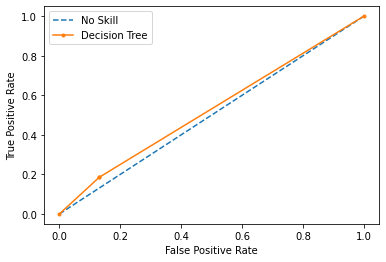

In [17]:
# PLotting the AUC curve 

y_prob = model.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
y_probs = y_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, y_probs)
# summarize scores
print('Decision Tree : ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Model 2 : Logistic Regression 

In [18]:
# Logistic Regression 
# We will be creating a multinomial model as mentioned in the paper [1]
clf_log = LogisticRegression(multi_class='multinomial',random_state=42)
# Fitting Model 
log_model = clf_log.fit(X_train,y_train)

In [19]:
# Accuracy
accuracy_logistic_regression = log_model.score(X_test,y_test)
print("Accuracy of Logistic Regression Model : ",accuracy_logistic_regression)

Accuracy of Logistic Regression Model :  0.8865680067744667


In [20]:
# Y predicitons on Test Data 
y_pred_logistic_regression = log_model.predict(X_test)

# Classification Report 
print("Classification Report on Logistic Regression Model ")
print(classification_report(y_test, y_pred_logistic_regression))

# AUC score 
print(f"AUC score = {roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1])*100} %")

Classification Report on Logistic Regression Model 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     21971
           1       0.61      0.02      0.03      2828

    accuracy                           0.89     24799
   macro avg       0.75      0.51      0.48     24799
weighted avg       0.86      0.89      0.84     24799

AUC score = 63.658569606058435 %


Logistic: ROC AUC=0.637


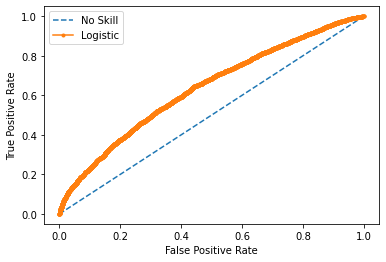

In [21]:
# PLotting the AUC curve for logistic Regression

y_prob = log_model.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
y_probs = y_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, y_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Model 3 : Randon Forest Classifier

In [22]:
# Random Forest Classifier
clf_random_forest = RandomForestClassifier(random_state=42)
# Fitting Model 
model_random_forest = clf_random_forest.fit(X_train,y_train)

In [23]:
# Accuracy
accuracy_random_forest = model_random_forest.score(X_test,y_test)
print("Accuracy of Random Forest : ",accuracy_random_forest)

Accuracy of Random Forest :  0.885076011129481


In [24]:
# Y predicitons on Test Data 
y_pred_random_forest = model_random_forest.predict(X_test)

# Classification Report 
print("Classification Report on Random Forest Model ")
print(classification_report(y_test, y_pred_random_forest))

# AUC score 
print(f"AUC score = {roc_auc_score(y_test, model_random_forest.predict_proba(X_test)[:,1])*100} %")

Classification Report on Random Forest Model 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     21971
           1       0.40      0.01      0.03      2828

    accuracy                           0.89     24799
   macro avg       0.64      0.51      0.48     24799
weighted avg       0.83      0.89      0.84     24799

AUC score = 62.51651431097582 %


Random Forest: ROC AUC=0.625


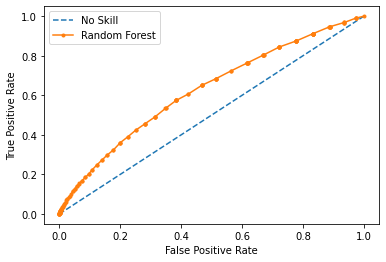

In [25]:
# PLotting the AUC curve for Random Forest

y_prob = model_random_forest.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
y_probs = y_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, y_probs)
# summarize scores
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

We can see from above 3 models that the accuracy and recall (for less than 30 days admission) compared below - 

 Model              | Accuracy  | Recall | 
-------------------|--------------------|--------|
# Deicion Tree       | 79.1%     | **0.19**   |
# Logistic Regression| **88.6%**     | 0.02   |
# Random Forest      | 88.5%     | 0.01   |

From the above comparision table we can see that the logistic regression model gives best accuracy and decision tree gices best recall. 

For this problem statement where we need to predict wheter the patient will be coming for early readmission or not we need to focus on recall more as it gives us how many patient which were coming back we predicted them to be true. 

So, eventhough Logistic Regression and Random Forest model looks good on accuracy but overall **Decision Tree **is best fit for this problem statement. 


In [26]:
# We will be hyper tuning our selected deciontree model with GridSearchCv

dtree = DecisionTreeClassifier()
tree_params =[{'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':list(range(1,40))}]
clf = GridSearchCV(dtree, tree_params, cv = 5, scoring='recall',n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 34, 'splitter': 'random'}


In [27]:
dtree_gcv = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=37,random_state=42)
model_tree = dtree_gcv.fit(X_train, y_train)
model_tree.score(X_test,y_test)

0.7911609339086253

In [28]:
# Y predicitons on Test Data 
y_pred = model_tree.predict(X_test)

# Classification Report 
print("Classification Report on Decision Tree Model ")
print(classification_report(y_test, y_pred))

# AUC score 
print(f"AUC score = {roc_auc_score(y_test, model_tree.predict_proba(X_test)[:,1])*100} %")

Classification Report on Decision Tree Model 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     21971
           1       0.15      0.19      0.17      2828

    accuracy                           0.79     24799
   macro avg       0.52      0.53      0.52     24799
weighted avg       0.81      0.79      0.80     24799

AUC score = 52.726024925359695 %


After hypertunung with GridSearchCV we see no chnage in recall and accuracy 
so we consider our model as best fit for this dataset. 

As we can see from above analysis that the recall of model is not increasing above 0.19 due to class imbalance problem. 

To resolve the issue of class imbalance we will be using a techique call undersampleling of data for '0' class as it has high number of rows. 
For this we will be using RandomUnderSampler Library. 

In [29]:
# RandomUnderSampler 
under = RandomUnderSampler()
# transform the dataset, it checks the train data and reduces the number of samples.
X_train, y_train = under.fit_resample(X_train, y_train)
# New class distribution 
counter = Counter(y_train)
print("New Distribution ",counter)
# Fitting the model of decision tree on new data 
model_undersampled = clf.fit(X_train,y_train)

New Distribution  Counter({0: 8486, 1: 8486})


In [30]:
# Accuracy
accuracy_undersampled = model_undersampled.score(X_test,y_test)
print("Accuracy of Decision Tree with Undersampled data : ",accuracy_undersampled)

Accuracy of Decision Tree with Undersampled data :  0.743988684582744


In [31]:
# Y predicitons on Test Data 
y_pred_undersampled = model_undersampled.predict(X_test)

# Classification Report 
print("Classification Report on Decision Tree with Undersampled Data ")
print(classification_report(y_test, y_pred_undersampled))

# AUC score 
print(f"AUC score = {roc_auc_score(y_test, model_undersampled.predict_proba(X_test)[:,1])*100} %")

Classification Report on Decision Tree with Undersampled Data 
              precision    recall  f1-score   support

           0       0.93      0.45      0.60     21971
           1       0.15      0.74      0.25      2828

    accuracy                           0.48     24799
   macro avg       0.54      0.60      0.43     24799
weighted avg       0.84      0.48      0.56     24799

AUC score = 62.64527717100663 %


After undersampling we can see a significant rise in the recall value. 

Decision Tree with Undersampled Data: ROC AUC=0.626


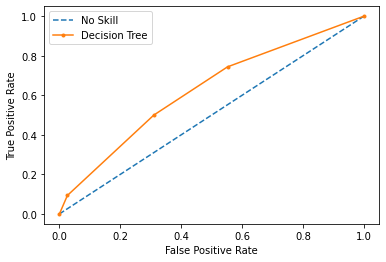

In [33]:
# PLotting the AUC curve for Decision Tree with undersampled data

y_prob = model_undersampled.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
y_probs = y_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, y_probs)
# summarize scores
print('Decision Tree with Undersampled Data: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

There is a slight improvement in AUC score after undersampling the data. 

From above comparision of 3 Models we can say that the decision tree is best fit for this problem statement. 

 Model              | Accuracy  | Recall | 
-------------------|--------------------|--------|
# Deicion Tree       | 79.1%     | **0.19**   |
# Logistic Regression| **88.6%**     | 0.02   |
# Random Forest      | 88.5%     | 0.01   |

Comparision of Decision Tree after undersamping of data - 

 Model              | Accuracy  | Recall | 
-------------------|--------------------|--------|
# Deicion Tree       |**79.1%**     | 0.19   |
# Undersampled Decsion Tree | 74.39%     | **0.74**   |

After Undersampling the data we can say that there is decrease in accuracy and increase in recall. As in this problem we have more focus in recall we decided to undersample.

There is need of more data of patient getting readmitted to generate better model.

References - 

[1] - https://downloads.hindawi.com/journals/bmri/2014/781670.pdf

[2] - https://en.wikipedia.org/wiki/List_of_ICD-9_codes

[3] - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2